In [1]:
# removes annoying deprecation warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
from google.cloud import bigquery
from bq_helper import BigQueryHelper #third party library to translate google query data to dataframe
import matplotlib.pyplot as plt
import os, sys

sys.path.insert(0, './../utils/')

# custom files 
import random_forest_regressor as rfr
import utilities as util
import validation as cv
from sklearn.model_selection import RepeatedKFold

from sklearn.model_selection import train_test_split
from sklearn import cross_validation

%matplotlib inline

with open('../../key.txt') as f:
    content = f.readlines()

#add your own key here 
os.environ['GOOGLE_APPLICATION_CREDENTIALS']= content[0]

/home/kristina/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
EPA_QUERY = """
        SELECT
            avg(arithmetic_mean) as am,
            CONCAT(cast(EXTRACT(YEAR FROM CO_daily.date_local) as string),
            cast(EXTRACT(MONTH FROM CO_daily.date_local) as string), 
            cast(EXTRACT(DAY FROM CO_daily.date_local) as string)) as date
        FROM
          `bigquery-public-data.epa_historical_air_quality.co_daily_summary` as CO_daily
        WHERE state_name ="California" AND city_name="San Francisco"
        GROUP BY date
        ORDER BY date DESC
        """

bq_assistant_CO = BigQueryHelper("bigquery-public-data", "epa_historical_air_quality")
df_CO = bq_assistant_CO.query_to_pandas(EPA_QUERY)

In [3]:
df_CO.head()

,am,date
0,0.593479,201799
1,0.595652,201798
2,0.600000,201797
3,0.591304,201796
4,0.557608,201795


In [4]:
SF_CRIME_QUERY = """
        SELECT
          COUNT( DISTINCT unique_key) as count,
          CONCAT(cast(EXTRACT(YEAR FROM SFCrimeData.timestamp) AS string), 
          cast(EXTRACT(MONTH FROM SFCrimeData.timestamp) AS string), 
          cast(EXTRACT(DAY FROM SFCrimeData.timestamp) AS string)) AS date
        FROM
          `bigquery-public-data.san_francisco_sfpd_incidents.sfpd_incidents` AS SFCrimeData
        WHERE category != "NON-CRIMINAL" AND category != "RECOVERED VEHICLE"
        GROUP BY date
        ORDER BY date DESC
        """
bq_assistant_SF_crime = BigQueryHelper("bigquery-public-data", "san_francisco_sfpd_incidents.sfpd_incidents")
df_SF_crime = bq_assistant_SF_crime.query_to_pandas(SF_CRIME_QUERY)

In [5]:
df_SF_crime.head()

,count,date
0,190,201859
1,192,201858
2,167,201857
3,191,201856
4,223,201855


In [6]:
df_SF_census = pd.read_csv('../../data/censuspopulationsf.tsv', sep='\t', header=None)
df_SF_census.columns = ['year', 'pop']
df_SF_census.head(n=20)

,year,pop
0,2003,757638
1,2004,750133
2,2005,748846
3,2006,751431
4,2007,758348
5,2008,767067
6,2009,774347
7,2010,805770
8,2011,816294
9,2012,830406


In [7]:
# make column for counts per capita
util.per_capita(df_SF_crime, df_SF_census)
# merge CO and Crime data
df_merged = util.merge_data(df_CO, df_SF_crime)
df_merged.head()

,am,date,count,per_capita
135,0.593479,201799,290,0.000328
136,0.595652,201798,319,0.000361
137,0.600000,201797,264,0.000299
138,0.591304,201796,269,0.000304
139,0.557608,201795,258,0.000292


In [8]:
# find optimum regressor
regr = rfr.find_regressor(df_merged[['date','am']].as_matrix(), df_merged['per_capita'].values)
regr

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/kristina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   0.4s
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   0.4s
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   0.4s
[CV] n_estimators=250, min_samples_split=2, max_depth=10, bootstrap=False 
[CV]  n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True, total=   0.5s
[CV] n_estimators=250, min_samples_split=2, max_depth=10, bootstrap=False 
[CV]  n_estimators=275, min_samples_split=4, max_d

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.8s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [9]:
# split dataset 
X_train, X_test, y_train, y_test = train_test_split(df_merged[['date','am']], df_merged['per_capita'].values, test_size=0.33, random_state=42)
# make predictions based on optimum regressor
y_pred = rfr.fit_and_predict(regr, X_train, X_test, y_train, y_test)

./../utils/random_forest_regressor.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  regr.fit(X_train.as_matrix(), y_train)
./../utils/random_forest_regressor.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return regr.predict(X_test.as_matrix())


In [10]:
cv.MSE(y_test, y_pred)
# leave one out cross validation 
# loo = cross_validation.LeaveOneOut(len(df_merged['per_capita'].values))
# loo_score = cv.Cross_Validation(loo, regr, df_merged[['date','am']].as_matrix(), df_merged['per_capita'].values)

7.897421779846798e-09

In [11]:
# 10 fold tss cross validation
tss_score = cv.Cross_Validation(df_merged[['date','am']], df_merged['per_capita'], regr, 10)
print('10-fold cross validation using time series split (additive): {} '.format(tss_score))

10-fold cross validation using time series split (additive): 8.866974704238635e-09 


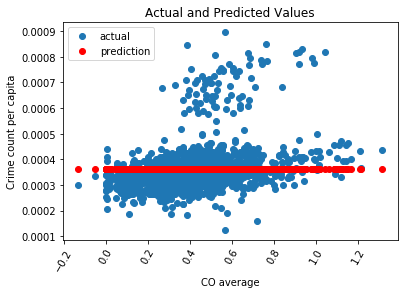

In [12]:
plt.plot(X_test['am'], y_test, 'o', label = 'actual')
plt.plot(X_test['am'], y_pred, 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
plt.xlabel('CO average'); plt.ylabel('Crime count per capita'); plt.title('Actual and Predicted Values');

In [13]:
df_merged.corr()

,am,count,per_capita
am,1.000000,0.256674,0.312716
count,0.256674,1.000000,0.968847
per_capita,0.312716,0.968847,1.000000
